In [49]:
import scipy as sp
import scipy.stats as sps
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import jenkspy as jp
import math
from sklearn.manifold import MDS


In [141]:
NUM_VARS = 4
NUM_SETS = 6
NUM_BINS = 3

var_stats = {"mean": np.repeat(0, NUM_VARS), "sd": np.repeat(1, NUM_VARS)}
set_stats = [
    0.46,
    0.25,
    0.16,
    0.11,
    0.1,
    0.09,
]  # from imdb dataset - could also round this to nice numbers idk (.5, .25, .15, .1, .1, .1)

var_names = list(map(lambda i: f"V{i}", range(NUM_VARS)))
varz_names = list(map(lambda vn: f"{vn}_z", var_names))
varb_names = list(map(lambda vn: f"{vn}_b", var_names))

set_names = list(map(lambda i: f"S{i}", range(NUM_SETS)))


In [142]:
def mvnorm(means, sds, size=10, random_state=None):
    dist = sps.multivariate_normal(means, sds)
    return dist.rvs(size=size, random_state=random_state)


def rvs(means, sds, limits, size=10, random_state=None):
    """Returns samples of D truncated normal distributions with the provided means, SDs and limits.
    The distributions are assumed to be independent, hence each dimension is sampled individually.
    The provided limits are assumed to be in sample space (as opposed to standard deviations).
    Note that SD and limits are dependent, i.e., if the limits are too narrow, the SD of the resulting
    distribution will be smaller than what was asked for."""
    D = min(len(means), len(sds), len(limits))
    result = np.empty((size, D))
    for i in range(D):
        l, r = limits[i]
        m = means[i]
        s = sds[i]
        a, b = (l - m) / s, (r - m) / s
        samples = sps.truncnorm.rvs(
            a, b, loc=m, scale=s, size=size, random_state=random_state
        )
        result[:, i] = samples
    return result


In [143]:
means = var_stats["mean"]
sds = var_stats["sd"]


def make_dataset(
    cluster1_size=20,
    cluster2_size=5,
    cluster2_shift_direction=[],
    cluster2_shift_distance=8,
    cluster2_sd_relative_to_cluster1=0.5,
):
    num_directions = len(list([d for d in cluster2_shift_direction if d != 0]))
    samples1 = mvnorm(means, sds, size=cluster1_size)

    shifted_means = np.copy(means)
    for i,dir in enumerate(cluster2_shift_direction):
        shift = dir * cluster2_shift_distance / num_directions
        shifted_means[i] += shift
    shifted_sds = np.copy(sds)
    shifted_sds = cluster2_sd_relative_to_cluster1 * sds
    samples2 = mvnorm(shifted_means, shifted_sds, size=cluster2_size)

    samples = np.concatenate((samples1, samples2))

    data = {}
    for i in range(NUM_VARS):
        x = samples[:, i]
        xz = sps.zscore(x)
        data[f"V{i}"] = x
        data[f"V{i}_z"] = xz
        jnb = jp.JenksNaturalBreaks(NUM_BINS)
        jnb.fit(x)
        data[f"V{i}_b"] = jnb.labels_

    data["cluster"] = np.concatenate(
        (np.repeat(0, cluster1_size), np.repeat(1, cluster2_size))
    )
    df = pd.DataFrame(data=data)

    for i in range(NUM_SETS):
        freq = set_stats[i]
        df[f"S{i}"] = sps.binom.rvs(1, freq, size=cluster1_size + cluster2_size)

    # now a bit of postprocessing
    # regarding sets
    set_names = list(map(lambda i: f"S{i}", range(NUM_SETS)))
    # we want all sets to have at least one element in each cluster
    # which at the same time ensures that no set has a single or no element
    genre_colsums = df[set_names + ["cluster"]].groupby("cluster").sum()
    for cluster in range(2):
        for genre in set_names:
            count = genre_colsums.loc[cluster, genre]
            if count == 0:
                # take random row of that cluster and add the set there
                randrow_start = 0 if cluster == 0 else cluster1_size
                randrow_end = (
                    cluster1_size if cluster == 0 else cluster1_size + cluster2_size
                )
                randrow = np.random.choice(
                    range(randrow_start, randrow_end), 1, replace=False
                )
                df.loc[randrow[0], genre] = 1
    # do the same sort of thing row-wise
    # there could be movies not in any set/genre, and we don't want that
    for i in range(df.shape[0]):
        while df.loc[i][set_names].sum() < 1:
            for j, genre in enumerate(set_names):
                # do the drawing again
                freq = set_stats[j]
                flag = sps.binom.rvs(1, freq, size=1)
                df.loc[i, genre] = flag

    return df


In [144]:
dataset = make_dataset(cluster2_shift_distance=6, cluster2_shift_direction=[0, 0, -1, 0])


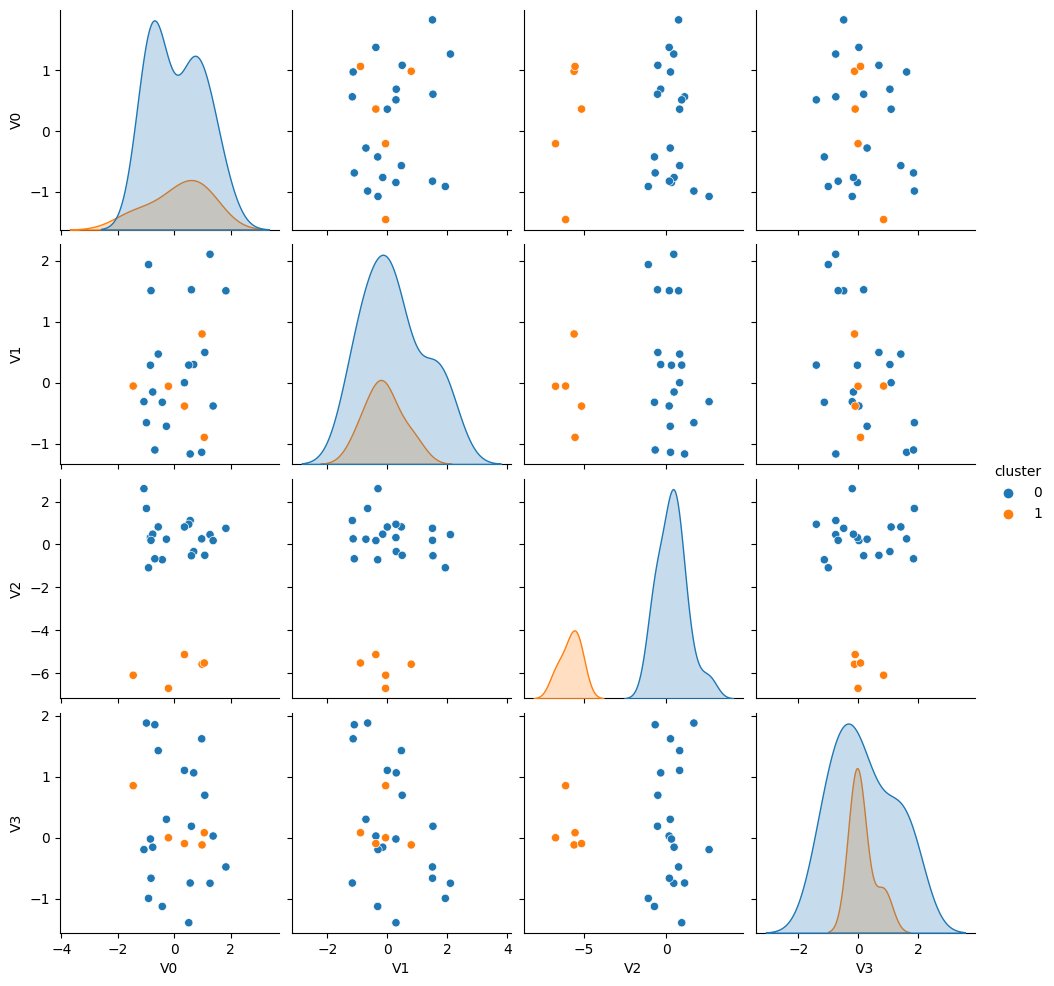

In [145]:
sns.pairplot(dataset[var_names + ["cluster"]], hue="cluster")


/usr/local/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<Axes: xlabel='mdsx', ylabel='mdsy'>

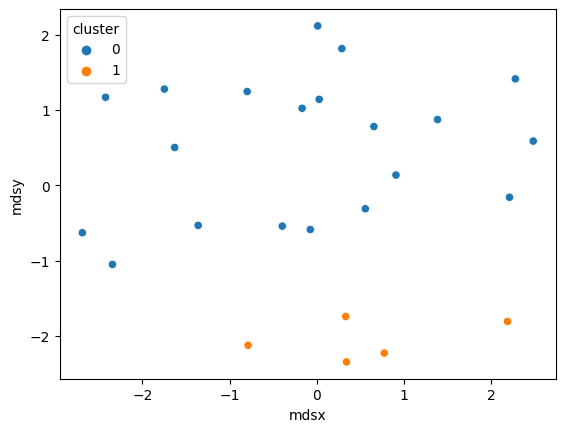

In [146]:
# quickly check the projection - we want the orange points bunched together
mds = MDS(n_components=2, metric=True, random_state=2, dissimilarity="euclidean")
# H_mds = mds.fit_transform(sps.zscore(dataset[varz_names]))
H_mds = mds.fit_transform(dataset[varz_names])

sns.scatterplot(
    pd.DataFrame(
        data={
            "mdsx": H_mds[:, 0],
            "mdsy": H_mds[:, 1],
            "cluster": dataset["cluster"],
        }
    ),
    x="mdsx",
    y="mdsy",
    hue="cluster",
)


In [147]:
dataset

,V0,V0_z,V0_b,V1,V1_z,V1_b,V2,V2_z,V2_b,V3,V3_z,V3_b,cluster,S0,S1,S2,S3,S4,S5
0,1.266129,1.278922,2,2.103817,2.081242,2,0.461090,0.517204,1,-0.747921,-1.013907,0,0,0,0,0,0,1,0
1,-0.912281,-1.119618,0,1.935211,1.901065,2,-1.084828,-0.079233,1,-0.995883,-1.286734,0,0,1,1,0,1,0,0
2,1.375804,1.399681,2,-0.379978,-0.572997,0,0.181759,0.409434,1,0.026717,-0.161592,1,0,0,1,0,0,0,0
3,1.828197,1.897788,2,1.505870,1.442262,2,0.753823,0.630144,2,-0.480363,-0.719520,0,0,1,0,0,0,0,0
4,-0.426011,-0.584210,0,-0.319182,-0.508029,0,-0.710990,0.064999,1,-1.128355,-1.432489,0,0,0,1,0,0,0,1
5,0.562748,0.504464,1,-1.165048,-1.411941,0,1.117286,0.770373,2,-0.744001,-1.009594,0,0,1,0,0,0,0,0
6,-0.280189,-0.423653,0,-0.711860,-0.927653,0,0.246476,0.434402,1,0.300846,0.140025,1,0,1,0,0,0,1,0
7,-0.569570,-0.742276,0,0.469667,0.334953,1,0.819584,0.655515,2,1.427220,1.379346,2,0,1,0,0,0,0,0
8,-0.987452,-1.202386,0,-0.653566,-0.865359,0,1.679369,0.987232,2,1.879746,1.877249,2,0,1,0,0,0,0,0
9,-0.847004,-1.047745,0,0.287603,0.140395,1,0.320791,0.463074,1,-0.022301,-0.215526,1,0,1,0,0,0,0,0


In [150]:
from PIL import Image, ImageDraw, ImageFont


def add_corners(im, rad):
    circle = Image.new("L", (rad * 2, rad * 2), 0)
    draw = ImageDraw.Draw(circle)
    draw.ellipse((0, 0, rad * 2 - 1, rad * 2 - 1), fill=255)
    alpha = Image.new("L", im.size, 255)
    w, h = im.size
    alpha.paste(circle.crop((0, 0, rad, rad)), (0, 0))
    alpha.paste(circle.crop((0, rad, rad, rad * 2)), (0, h - rad))
    alpha.paste(circle.crop((rad, 0, rad * 2, rad)), (w - rad, 0))
    alpha.paste(circle.crop((rad, rad, rad * 2, rad * 2)), (w - rad, h - rad))
    im.putalpha(alpha)
    return im


def expand2square(pil_img, background_color=(0, 0, 0)):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result


def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result


fw, fh = (500, 500)
margin = 15

num_rows = 2
num_cols = 2
side_x = fw / num_cols - margin
side_y = fh / num_rows - margin
area_per_var = side_x * side_y / NUM_VARS


def make_glyphs(name, mdf):
    result = []
    for i in mdf.index:
        datacase = mdf.loc[i]
        img = Image.new(mode="RGB", size=(fw, fh))
        img = add_corners(img, 30)
        fnt = ImageFont.truetype("Arial.ttf", 40)
        d = ImageDraw.Draw(img)

        for j, var in enumerate(var_names):
            row = j // num_rows
            col = j % num_rows
            cx, cy = col*margin + col * side_x + side_x / 2, row*margin+row * side_y + side_y / 2

            bin = NUM_BINS - datacase[var + "_b"]  # invert 1-based bins
            area = area_per_var * 1 / bin**2
            # area = pi x r^2
            # r = math.swrt(area / math.pi)
            side = math.sqrt(area)  # TODO aspect ratio
            rect = [(cx - side, cy - side), (cx + side, cy + side)]
            d.ellipse(rect, fill=(255,255,255), width=0)
            #d.circle((cx,cy), fill=(255, 255, 255), width=0)

        filename = f"{name}_{i}_thumb.png"
        img.save(f'./img/{filename}', "PNG")
        result.append(f'eval/dataset/img/{filename}')
    return result


In [151]:
import json
import random
import scipy.spatial.distance as scidist

NUM_DATASETS = 2


for i in range(NUM_DATASETS):
    ds_name = f"dataset{i}"
    num_cluster_defining_vars = random.randint(2, NUM_VARS-1)
    cluster_defining_vars = random.sample(range(NUM_VARS), k=num_cluster_defining_vars)
    cluster_defining_direction = random.choices([-1,1], k=num_cluster_defining_vars)
    cluster_definers = zip(cluster_defining_vars, cluster_defining_direction)

    shift_direction = np.repeat(0, NUM_VARS)
    for v,d in cluster_definers:
        shift_direction[v] = d

    print('shift dataset', i, shift_direction)

    df = make_dataset(
        cluster1_size=10,
        cluster2_size=5,
        cluster2_shift_direction=shift_direction,
        cluster2_shift_distance=NUM_VARS*2,
    )
    glyphs = make_glyphs(ds_name, df)

    ds_dists = scidist.squareform(scidist.pdist(df[var_names], scidist.euclidean))
    set_dists = scidist.squareform(scidist.pdist(df[set_names], scidist.jaccard))

    sets_per_row = []
    for j in df.index:
        sets_per_row.append([g for g in set_names if df.loc[j, g] == 1])

    with open(f'{ds_name}_meta.json', 'w') as f:
        json.dump({
            'cluster_defining_vars': cluster_defining_vars
        }, f)

    with open(f"{ds_name}.json", "w", encoding="utf8") as f:
        jsonstr = {
            "glyph_ids": glyphs,
            "E": list(map(lambda x: str(x), df.index.tolist())),
            "EA": ds_dists.tolist(),
            "SR": sets_per_row,
            "S": set_names,
            "SA": set_dists.tolist(),
        }
        json.dump(jsonstr, f, ensure_ascii=False)

shift dataset 0 [ 0  0  1 -1]
shift dataset 1 [ 1  0  0 -1]
